# Mediapipe face mesh

In [1]:
import cv2
import mediapipe as mp
import numpy as np
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

2024-06-09 14:30:32.456498: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 14:30:32.751595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 14:30:33.744735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# FUNCTION TO EXTRACT MASK FROM MEDIAPIPE IMAGES


def get_points(image, results):
    '''Extracts the skin landmarks (x,y) coordinates detected by MediaPipe Face Mesh from the detected face.
    Length may vary if several faces are detected.
    Input :
    - image : The original image (must be in RGB format)
    - results : The output of the MediaPipe Face Mesh model'''
    # Define indices for the facial landmarks that typically represent the skin area
    skin_landmark_indices = list(range(0, 468))  # Indices for all landmarks
    points = []

    # Extract the skin landmarks from the detected face
    if results.multi_face_landmarks: # Check if any face is detected
        for face_landmarks in results.multi_face_landmarks: # take only first face
            for idx in skin_landmark_indices:
                x = int(face_landmarks.landmark[idx].x * image.shape[1])
                y = int(face_landmarks.landmark[idx].y * image.shape[0])
                points.append([x, y])

    points = np.array(points)
    return points

def get_mask_from_points(image, points):
    '''Returns the mask correponding to the skin area visible. 
    The mask is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format) - to get the size of the mask
    - points : The output of the MediaPipe Face Mesh model
    Output : .jpg image with only the skin area visible and rest of the image masked out (balck)'''

    # Create a mask for the skin area
    mask = np.zeros_like(image) # default mask is all black (zero values)
    if len(points) > 0: # if face is detected
        # Create a convex hull around the skin landmarks to approximate the skin area
        hull = cv2.convexHull(points)
        # Draw the convex hull on the mask
        cv2.fillConvexPoly(mask, hull, (255, 255, 255)) 

    return mask 

def get_masked_image(image, results) :
    '''Returns the mask correponding to the skin area visible. 
    The mask is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format)
    - results : The output of the MediaPipe Face Mesh model
    Output : .jpg image with only the skin area visible and rest of the image masked out (balck)'''
    
    # Extract list of skin landmarks from the detected face - (x,y) coordinates only
    points = get_points(image, results)

    # Create a mask for the skin area
    mask = get_mask_from_points(image, points)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, mask)

    return mask, masked_image

def get_mesh(image, results):
    '''Returns the image with the skin landmarks detected by MediaPipe Face Mesh overlayed on it.
    Input :
    - image : The original image (must be in RGB format)
    - points : List containing the 468 (x,y) coordinates of the landmarks obtained with MediaPipe Face Mesh model
    Output : .jpg image with the skin landmarks overlayed on the original image'''

    # Copy the original image
    meshed_image = image.copy()

    # Draw the facial landmarks on the image using tesselation
    if results.multi_face_landmarks:
        for f, face_landmarks in enumerate(results.multi_face_landmarks):
            if f==0:
                # Draw the facial landmarks on the image using tesselation
                mp_drawing.draw_landmarks(
                    image=meshed_image,
                    landmark_list=face_landmarks,  # face_landmarks is a list of landmarks for one face (dictionnary with x, y & z keys)
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )

    return meshed_image

def get_contours(image, results):
    '''Returns the contour corresponding to the skin area visible. 
    The contour is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format) - to get the size of the mask
    - points : The output of the MediaPipe Face Mesh model
    Output : .jpg image with face contours)'''

    # Copy the original image
    contoured_image = image.copy()

    # Draw the facial landmarks on the image using tesselation
    if results.multi_face_landmarks:
        for f, face_landmarks in enumerate(results.multi_face_landmarks):
            if f==0:
                # Draw the facial landmarks on the image using tesselation
                mp_drawing.draw_landmarks(
                    image=contoured_image,
                    landmark_list=face_landmarks,  # face_landmarks is a list of landmarks for one face (dictionnary with x, y & z keys)
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )

    return contoured_image

def show_mask(image, meshed_image, mask, masked_image ):
    '''Display the original image, the landmarks, the mask and the masked image side by side'''
    plt.figure(figsize=(12, 3.5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(1, 4, 2)
    plt.imshow(meshed_image)
    plt.title('Landmarks (Mesh)')
    plt.subplot(1, 4, 3)
    plt.imshow(mask)
    plt.title('Mask')
    plt.subplot(1, 4, 4)
    plt.imshow(masked_image)
    plt.title('Skin Area')
    plt.suptitle('Skin Area Extraction with MediaPipe Face Mesh Model\n'+path)
    plt.show()


In [3]:
# open df_train.pkl

image_dir = "Data/crops_100K"

# open the file for reading
with open('Data/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

# reset the index
#df_train = df_train.reset_index(drop=True)
print(df_train.index)
df_train.head(-10)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            101335, 101336, 101337, 101338, 101339, 101340, 101341, 101342,
            101343, 101344],
           dtype='int64', length=101341)


,filename,FaceOcclusion,gender,black_and_white,db_number,count,gender_
0,database1/img00011271.jpg,0.019,0.999,False,1,1,1
1,database1/img00012471.jpg,0.035,1.000,False,1,1,1
2,database1/img00008127.jpg,0.127,0.001,False,1,1,0
3,database1/img00008972.jpg,0.014,0.999,False,1,1,1
4,database1/img00028187.jpg,0.346,0.982,False,1,1,1
...,...,...,...,...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000,False,3,1,1
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998,True,3,1,1
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000,True,3,1,1
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000,False,3,1,1


# 1/ Load the model

In [4]:
# Test with the mediapipe face mesh pretrained model
# download the mediapipe library   
# pip install mediapipe

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# 2/ Test on a color image and a "grayscale" image

Data/crops_100K/database1/img00011271.jpg


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717936239.617459    4041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717936239.621798    4041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


/home/anaele/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


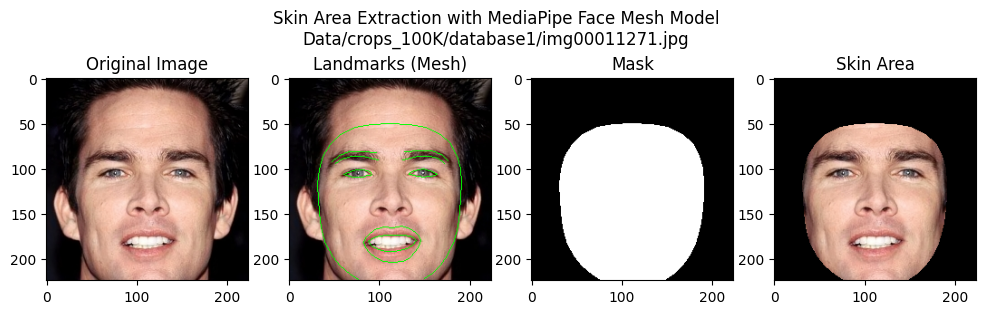

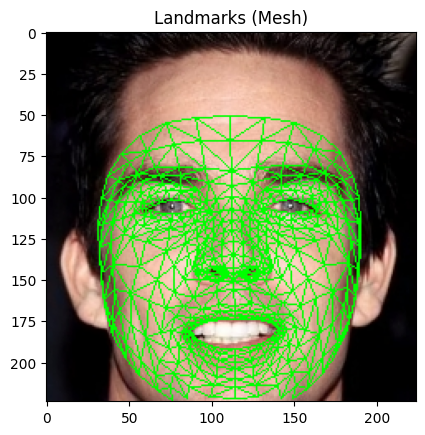

In [5]:
# Load your color image and convert it to RGB
#--------------------------------------------

# Load image
image_dir = "Data/crops_100K"
path = f"{image_dir}/{df_train.loc[0]['filename']}"
print(path)
image = cv2.imread(path)

# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply model
results = face_mesh.process(image)

# get the points and the masked image
mask, skin_area = get_masked_image(image,results)
mesh = get_mesh(image, results)
contours = get_contours(image, results)

# Display the original image and the skin area
show_mask(image, contours, mask, skin_area)

plt.imshow(mesh)
plt.title('Landmarks (Mesh)')
plt.show()

In [6]:
# get_masked_image() is equivalent to 

# get mask with mediapipe
results = face_mesh.process(image)       # Process the image to find face landmarks
points = get_points(image, results)      # Extract list of skin landmarks from the detected face - (x,y) coordinates only
mask = get_mask_from_points(image, points)          # Create a mask for the skin area
skin_area = cv2.bitwise_and(image, mask) # Apply the mask to the original image

print('image shape:',image.shape)
print('mask shape:',mask.shape)
print('masked image shpae:',skin_area.shape)

image shape: (224, 224, 3)
mask shape: (224, 224, 3)
masked image shpae: (224, 224, 3)


image_ shape: (224, 224, 3)
mask_ shape: (224, 224, 3)


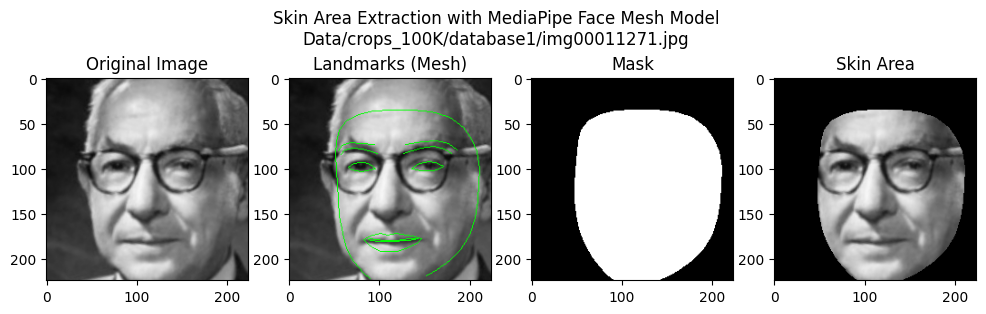

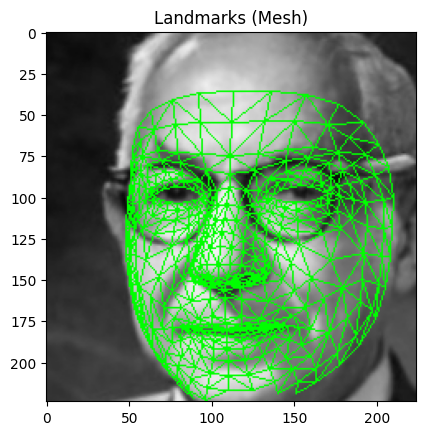

In [7]:
# Load a black and white image (3 channels)
# -----------------------------------------

# !!! Note : image must have 3 channels !)
path_ = "Data/crops_100K/database3/database3/m.01b_6y/40-FaceId-0_align.jpg"
image_ = cv2.imread(path_)
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
print("image_ shape:", image_.shape)

# get mask with mediapipe
results_ = face_mesh.process(image_)       # Process the image to find face landmarks
mask_, skin_area_ = get_masked_image(image_, results_) # Extract the skin landmarks and create a mask
contours_ = get_contours(image_, results_)
mesh_ = get_mesh(image_, results_)

print("mask_ shape:", mask_.shape)
show_mask(image_, contours_, mask_, skin_area_)
plt.imshow(mesh_)
plt.title('Landmarks (Mesh)')
plt.show()

In [8]:
# test with a black and white image (1 channel)
#----------------------------------------------

image_1_channel = image_[:,:,0]

# get mask with mediapipe
print("Extracting mask from a black and white image (1 channel)")
try:
    results = face_mesh.process(image_1_channel)
except:
    print("Error: image must have 3 channels")
    print("image_1 shape:", image_1_channel.shape)

Extracting mask from a black and white image (1 channel)
Error: image must have 3 channels
image_1 shape: (224, 224)


# 3/ Explore the output of the model

In [9]:
# Explore the results of the MediaPipe Face Mesh model
# ----------------------------------------------------

print("result type:", type(results))
print("result.multi_face_landmarks type:", type(results.multi_face_landmarks), "\n      length:", len(results.multi_face_landmarks))
print("result.multi_face_landmarks[0] type:", type(results.multi_face_landmarks[0]))
print("results.multi_face_landmarks[0].landmark type:", type(results.multi_face_landmarks[0].landmark), "\n      length:", len(results.multi_face_landmarks[0].landmark))
print("result.multi_face_landmarks[0].landmark[0] type:", type(results.multi_face_landmarks[0].landmark[0]))
print("\nlandmark point:\n", results.multi_face_landmarks[0].landmark[0])

result type: <class 'type'>
result.multi_face_landmarks type: <class 'list'> 
      length: 1
result.multi_face_landmarks[0] type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
results.multi_face_landmarks[0].landmark type: <class 'google._upb._message.RepeatedCompositeContainer'> 
      length: 468
result.multi_face_landmarks[0].landmark[0] type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmark'>

landmark point:
 x: 0.510595202
y: 0.741574943
z: -0.116614483



mask shape: (224, 224, 3)
mask type: <class 'numpy.ndarray'>
mask dtype: uint8
number of pixels in the mask: 50176
number of white pixels in the mask (=face): 23742 (47.32%)
number of black pixels in the mask (=background): 26434 (52.68%)
values in the mask [  0 255]


Text(0.5, 1.0, 'Channel 2 \n(gray colormap)')

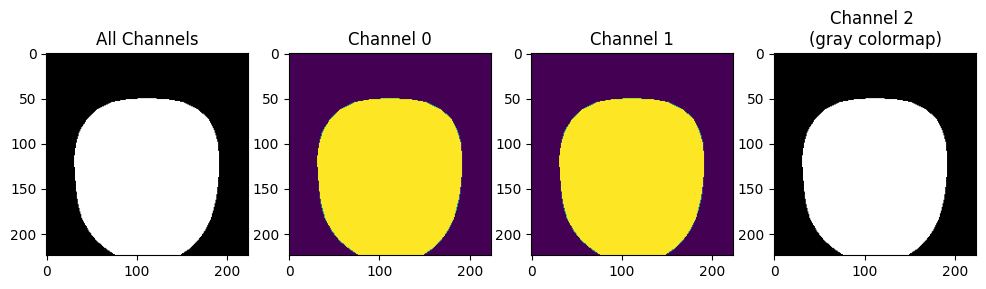

In [10]:
# explore the mask (white = 255 and black = 0)
# ----------------------------------------------
print("mask shape:", mask.shape)
print("mask type:", type(mask))
print("mask dtype:", mask.dtype)
print("number of pixels in the mask:", mask.shape[0] * mask.shape[1])
print(f"number of white pixels in the mask (=face): {np.sum(mask[:,:,0] == 255)} ({np.sum(mask[:,:,0] == 255) / (mask.shape[0] * mask.shape[1]) * 100:.2f}%)")
print(f"number of black pixels in the mask (=background): {np.sum(mask[:,:,0] == 0)} ({np.sum(mask[:,:,0] == 0) / (mask.shape[0] * mask.shape[1]) * 100:.2f}%)")
print("values in the mask",np.unique(mask))

# Show the mask in different channels
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(mask)
plt.title('All Channels')
plt.subplot(1, 4, 2)
plt.imshow(mask[:,:,0])
plt.title('Channel 0')
plt.subplot(1, 4, 3)
plt.imshow(mask[:,:,1])
plt.title('Channel 1')
plt.subplot(1, 4, 4)
plt.imshow(mask[:,:,2], cmap='gray')
plt.title('Channel 2 \n(gray colormap)') 

# 4/ Process all images
=> masked images stored in a new directory "masked_images"<br>
=> mediapipe face mesh keypoints (468) stored in a new directory "mesh_keypoints"

In [13]:
# Process all the images
#-----------------------

# Initialize variables
mask_dict = {}
face_pixels = []
image_pixels = []
image_size = []
mask_filename = []

# Process all the images (loop over the images)
for i in df_train.index :
    if i == 100: print(i)
    if i == 1000: print(i)
    if i % 5000 == 0: print(i)
    
    # load image (.loc will use index, whereas iloc will use row number)
    path = f"{image_dir}/{df_train.loc[i]['filename']}"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # get the keypoints and save to file
    try :
        results = face_mesh.process(image)
        mask, skin_area = get_masked_image(image, results)
        cv2.imwrite('Data/masked_images/' + str(i) + '_masked.jpg', cv2.cvtColor(skin_area, cv2.COLOR_RGB2BGR))
        mask_filename.append(str(i) + '_masked.jpg')
        cv2.imwrite('Data/meshed_images/' + str(i) + '_mesh.jpg', cv2.cvtColor(get_mesh(image, results), cv2.COLOR_RGB2BGR))
        cv2.imwrite('Data/contoured_images/' + str(i) + '_contour.jpg', cv2.cvtColor(get_contours(image, results), cv2.COLOR_RGB2BGR))
        # save the landmarks to a file
        if results.multi_face_landmarks:
            for f, face_landmarks in enumerate(results.multi_face_landmarks):
                if f==0:
                    landmarks_list = face_landmarks
                    with open('Data/mesh_keypoints/' + str(i) + '_landmarks.pkl', 'wb') as file:
                        pickle.dump(landmarks_list, file)

        # Save data to the mask_dict
        mask_dict[df_train.loc[i]['filename']] = mask
        image_pixels.append(mask.shape[0] * mask.shape[1])
        face_pixels.append(np.sum(mask[:,:,0] == 255))
        image_size.append((mask.shape[0] , mask.shape[1]))

    except UserWarning:
        print(f"Error with file {path}")

# Save the mask_dict to a file
with open('Data/mask_dict_fin.pkl', 'wb') as f: pickle.dump(mask_dict, f)

# Add new columns to the df_train and save
df_train['image_pixels'] = image_pixels
df_train['face_pixels'] = face_pixels
df_train['image_size'] = image_size
with open('Data/df_train.pkl', 'wb') as f: pickle.dump(df_train, f)

# show the df_train
df_train.head(-10)

0


/home/anaele/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


100
1000


In [ ]:
# Process all the images
#-----------------------

# Initialize variables
mask_dict = #{}
face_pixels = []
image_pixels = []
image_size = []
mask_filename = []
df_train.index

# Process all the images (loop over the images)
for i in df_train.index :
    if i == 100: print(i)
    if i == 1000: print(i)
    if i % 5000 == 0: print(i)
    
    # load image (.loc will use index, whereas iloc will use row number)
    path = f"{image_dir}/{df_train.loc[i]['filename']}"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()

    # get the keypoints and save to file
    try :
        
        # Process the image to find face landmarks
        results = face_mesh.process(image)
        
        # save the keypoints
        if results.multi_face_landmarks:
            face_landmarks_list = []
            for face_landmarks in results.multi_face_landmarks:
                landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
                face_landmarks_list.append(landmarks)

            with open('mesh_keypoints/' + str(i) + '_results.pkl', 'wb') as file:
                pickle.dump(face_landmarks_list, file)
            
            mask_filename.append(str(i) + '_results.pkl')
            

        # Create a mask for the skin area and the face area image
        mask = get_mask(image, results)
        skin_area = cv2.bitwise_and(image, mask) # Create the masked image
        cv2.imwrite('masked_images/' + str(i) + '_masked.jpg', cv2.cvtColor(skin_area, cv2.COLOR_RGB2BGR))

        # Save data to the mask_dict
        mask_dict[df_train.loc[i]['filename']] = mask
        image_pixels.append(mask.shape[0] * mask.shape[1])
        face_pixels.append(np.sum(mask[:,:,0] == 255))
        image_size.append((mask.shape[0] , mask.shape[1]))

    except UserWarning:
        print(f"Error with file {path}")

# Save the mask_dict to a file
with open('mask_dict_fin.pkl', 'wb') as f: pickle.dump(mask_dict, f)

# Add new columns to the df_train and save
df_train['image_pixels'] = image_pixels
df_train['face_pixels'] = face_pixels
df_train['image_size'] = image_size
with open('Data/df_train.pkl', 'wb') as f: pickle.dump(df_train, f)

# show the df_train
df_train.head(-10)

In [ ]:
# check number of image processed
print(len(face_pixels))
print(len(image_size))
print(len(mask_dict.keys()))

# Re-open files

In [ ]:
# open face landmarks (keypoints) file
n=0
landmarks = 'mesh_keypoints/'+str(n)+'0_landmarkss.pkl'
with open(landmarks, 'rb') as f:
    landmarks = pickle.load(f)
print(landmarks[0])


In [ ]:
# open result file and show photo with mask

with open("Data/mask_dict.pkl", 'rb') as f:
    mask_dict_ = pickle.load(f)

mask_dict_.keys()